In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 73.2 MB/s eta 0:00:00


In [ ]:
# import necessary libraries
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.metrics import average_precision_score
import json
import rasterio


import cv2
import torch
import torchvision
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T


from pycocotools.coco import COCO

In [ ]:
# define the directories
train_data_dir = '/content/data/Exercise_sheet4/images/train'
test_data_dir = '/content/data/Exercise_sheet4/images/test'

train_annotation_file = '/content/data/Exercise_sheet4/train.json'
test_annotation_file = '/content/data/Exercise_sheet4/test.json'

train_masks_dir = '/content/data/Exercise_sheet4/masks/train'
test_masks_dir = '/content/data/Exercise_sheet4/masks/test'

training_data = '/content/data/Exercise_sheet4/train/'
testing_data = '/content/data/Exercise_sheet4/test/'

In [ ]:
# make the directories
os.makedirs(train_masks_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)
os.makedirs(training_data, exist_ok=True)
os.makedirs(testing_data, exist_ok=True)

In [ ]:
# #### Utils
# ### Convert Annotations to mask
def convert_data_from_coco(annotation_file, data_dir, masks_dir,selected_dir):
  coco = COCO(annotation_file)
  img_ids = coco.getImgIds()
  # print(img_ids[0])
  for idx in range(len(img_ids)):
    anns_obj = coco.loadAnns(coco.getAnnIds(img_ids[idx]))
    img_obj = coco.loadImgs(img_ids[idx])[0]
    img = Image.open(os.path.join(data_dir, img_obj['file_name']))

    mask = torch.zeros(520, 704)
    mask = coco.annToMask(anns_obj[0])
    if mask.shape[0] != 520:
        mask = mask.reshape(520,704)
    for i in range(len(anns_obj)):
      temp = coco.annToMask(anns_obj[i])
      if temp.shape[0] != 520:
        temp = temp.reshape(520,704)
      mask += temp
    mask =  np.where(mask > 0, 1, 0)
    img.save(os.path.join(selected_dir, f"{img_obj['file_name'][:-4]}.png"))
    cv2.imwrite(os.path.join(masks_dir, f"{img_obj['file_name'][:-4]}_mask.png"), mask)




In [ ]:
convert_data_from_coco(train_annotation_file, train_data_dir, train_masks_dir,training_data)
convert_data_from_coco(test_annotation_file, test_data_dir, test_masks_dir,testing_data)

loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


In [ ]:
len(os.listdir(train_masks_dir))

352

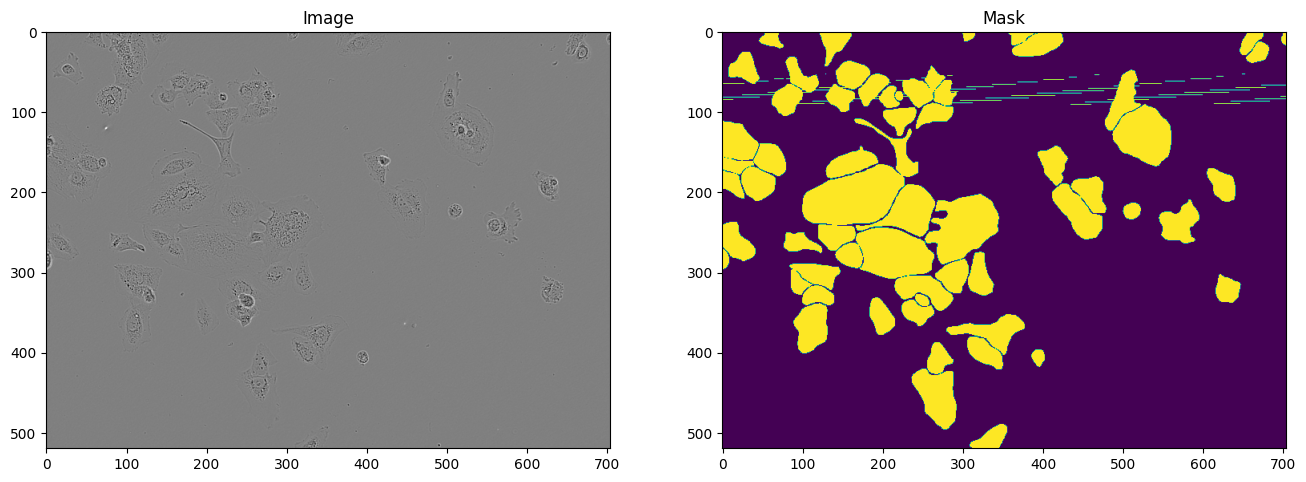

In [ ]:
image = Image.open("/content/data/Exercise_sheet4/images/train/Huh7_Phase_A10_2_00d20h00m_3.tif").convert('RGB')
mask = read_image("/content/data/Exercise_sheet4/masks/train/Huh7_Phase_A10_2_00d20h00m_3_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image)
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))


In [ ]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir,mask_dir, transforms):
        # self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        self.imgs = list(sorted(os.listdir(img_dir)))
        self.masks = list(sorted(os.listdir(mask_dir)))


    def __getitem__(self, idx):
        # load images and masks

        img_path = os.path.join(self.img_dir, self.imgs[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        img = rasterio.open(img_path)
        img = img.read()
        img = ToTensor()(img)
        mask = read_image(mask_path)

        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        img = img.permute(1,2,0)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [ ]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [ ]:
# data augmentation function
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [ ]:
import utils

from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and cell
num_classes = 2
# use our dataset and defined transformations
dataset = CocoDataset(training_data,train_masks_dir, None)
dataset_test = dataset = CocoDataset(testing_data,test_masks_dir, None)


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)


num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)



Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 61.8MB/s]
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch: [0]  [  0/100]  eta: 0:06:27  lr: 0.000055  loss: 4.4099 (4.4099)  loss_classifier: 0.6451 (0.6451)  loss_box_reg: 0.1025 (0.1025)  loss_mask: 3.5836 (3.5836)  loss_objectness: 0.0163 (0.0163)  loss_rpn_box_reg: 0.0624 (0.0624)  time: 3.8793  data: 0.0606  max mem: 2148
Epoch: [0]  [ 10/100]  eta: 0:01:12  lr: 0.000560  loss: 1.6280 (2.2115)  loss_classifier: 0.3638 (0.3575)  loss_box_reg: 0.0594 (0.0618)  loss_mask: 1.1758 (1.6234)  loss_objectness: 0.0671 (0.0957)  loss_rpn_box_reg: 0.0740 (0.0732)  time: 0.8098  data: 0.0373  max mem: 2317
Epoch: [0]  [ 20/100]  eta: 0:00:53  lr: 0.001065  loss: 1.1200 (1.5470)  loss_classifier: 0.0778 (0.2187)  loss_box_reg: 0.0586 (0.0618)  loss_mask: 0.7530 (1.1286)  loss_objectness: 0.0461 (0.0698)  loss_rpn_box_reg: 0.0652 (0.0681)  time: 0.5018  data: 0.0350  max mem: 2318
Epoch: [0]  [ 30/100]  eta: 0:00:43  lr: 0.001569  loss: 0.6129 (1.2284)  loss_classifier: 0.0541 (0.1632)  loss_box_reg: 0.0636 (0.0634)  loss_mask: 0.4105 (0.8863) 

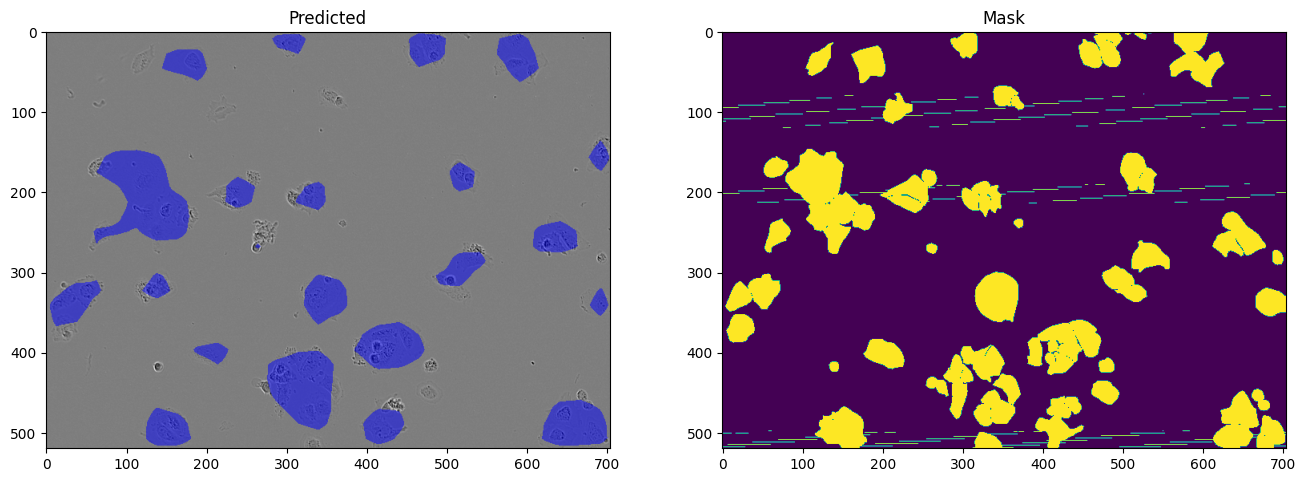

In [ ]:
### display predeicted and actual mask side by side
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.io import ImageReadMode

image = read_image("/content/data/Exercise_sheet4/test/Huh7_Phase_A12_1_00d00h00m_1.png", ImageReadMode.RGB)
actual_mask = read_image("/content/data/Exercise_sheet4/masks/test/Huh7_Phase_A12_1_00d00h00m_1_mask.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)

    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"cell: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]

masks = (pred["masks"] > 0.5).squeeze(1)
output_image = draw_segmentation_masks(image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Predicted")
plt.imshow(output_image.permute(1,2,0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(actual_mask.permute(1,2,0))

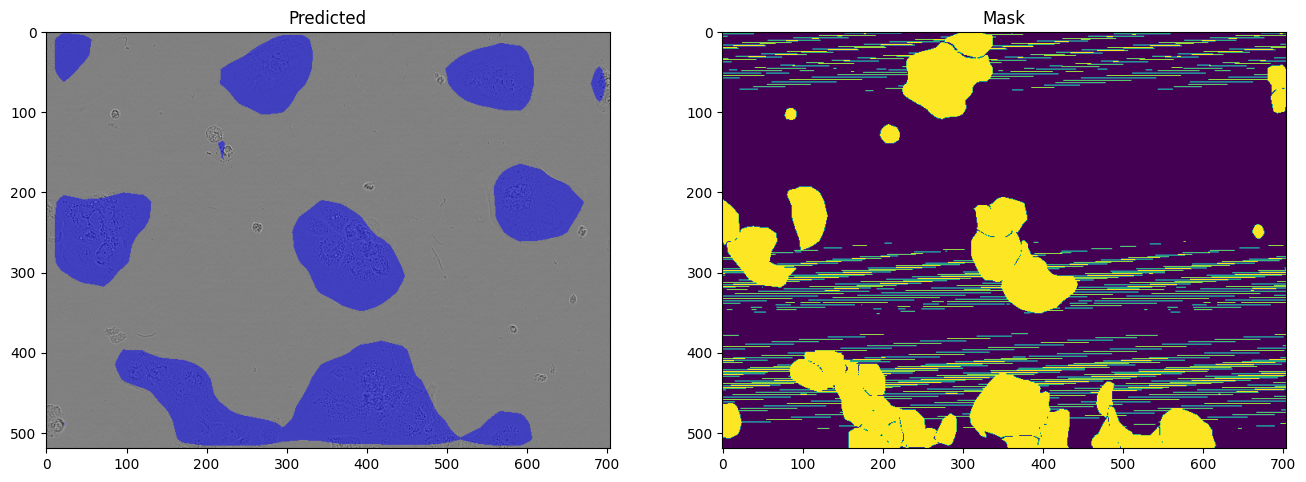

In [ ]:

image = read_image("/content/data/Exercise_sheet4/test/Huh7_Phase_A12_2_03d20h00m_3.png", ImageReadMode.RGB)
actual_mask = read_image("/content/data/Exercise_sheet4/masks/test/Huh7_Phase_A12_2_03d20h00m_3_mask.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)

    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"cell: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]

masks = (pred["masks"] > 0.5).squeeze(1)
output_image = draw_segmentation_masks(image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Predicted")
plt.imshow(output_image.permute(1,2,0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(actual_mask.permute(1,2,0))

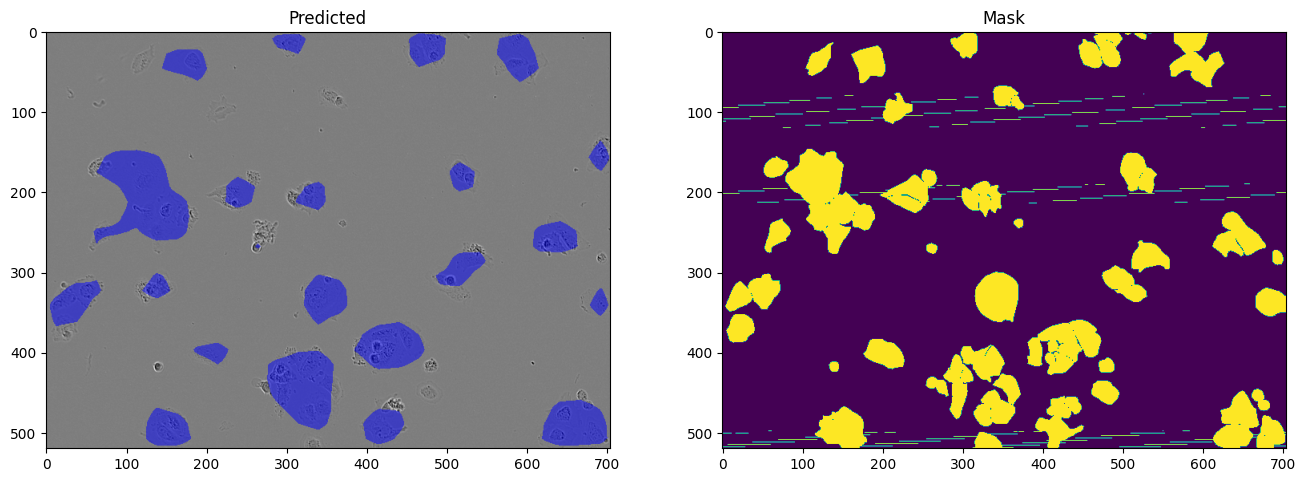

In [ ]:

image = read_image("/content/data/Exercise_sheet4/test/Huh7_Phase_A12_1_00d00h00m_1.png", ImageReadMode.RGB)
actual_mask = read_image("/content/data/Exercise_sheet4/masks/test/Huh7_Phase_A12_1_00d00h00m_1_mask.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)

    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"cell: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]

masks = (pred["masks"] > 0.5).squeeze(1)
output_image = draw_segmentation_masks(image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Predicted")
plt.imshow(output_image.permute(1,2,0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(actual_mask.permute(1,2,0))